In [9]:
# !pip install eda_toolkit
# !pip install model_metrics
from datetime import datetime
from eda_toolkit import flex_corr_matrix
import kagglehub
import math
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from model_metrics import summarize_model_performance
from model_metrics import show_roc_curve
from model_metrics import show_confusion_matrix
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, chi2_contingency
from textwrap import dedent
import time
import warnings


# ====== Significance Tesing ========

age
p = 0.000 
mean0 = 53.993
mean1 = 56.298


pack_years
p = 0.000 
mean0 = 1.486
mean1 = 20.631


oxygen_saturation
p = 0.000 
mean0 = 97.594
mean1 = 91.546


copd
p = 0.000
Significant 
P(copd=1 | Low) = 0.030
P(copd=1 | High) = 0.551


family_history_cancer
p = 0.000
Significant 
P(family_history_cancer=1 | Low) = 0.189
P(family_history_cancer=1 | High) = 0.248


chronic_cough
p = 0.000
Significant 
P(chronic_cough=1 | Low) = 0.036
P(chronic_cough=1 | High) = 0.586


shortness_of_breath
p = 0.000
Significant 
P(shortness_of_breath=1 | Low) = 0.049
P(shortness_of_breath=1 | High) = 0.659


INTERPRETATION
---------------
For the CONTINUOUS features:

AGE:
HIgh risk patients are, on average, older
(mean_high = 56.298 vs
mean_low = 53.993)
p < 0.001, meaning a significant difference.

PACK_YEARS:
High risk patients typically have more years smoking.
mean_high = 20.631
mean_low = 1.486
p < 0.001, so smoking history has a strong association with ris

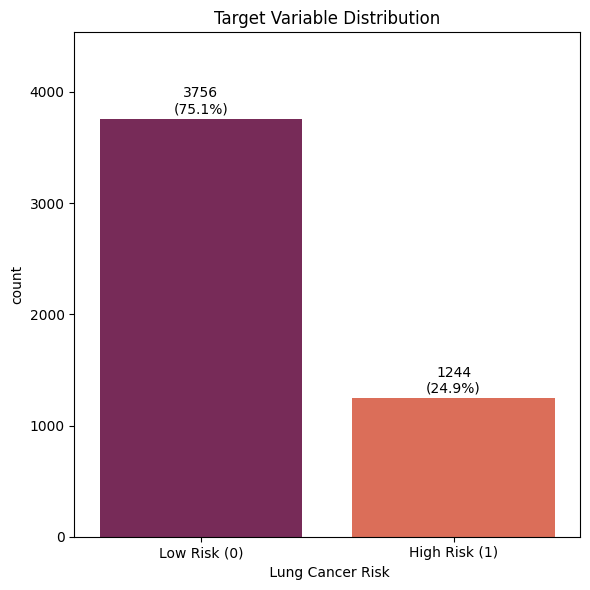

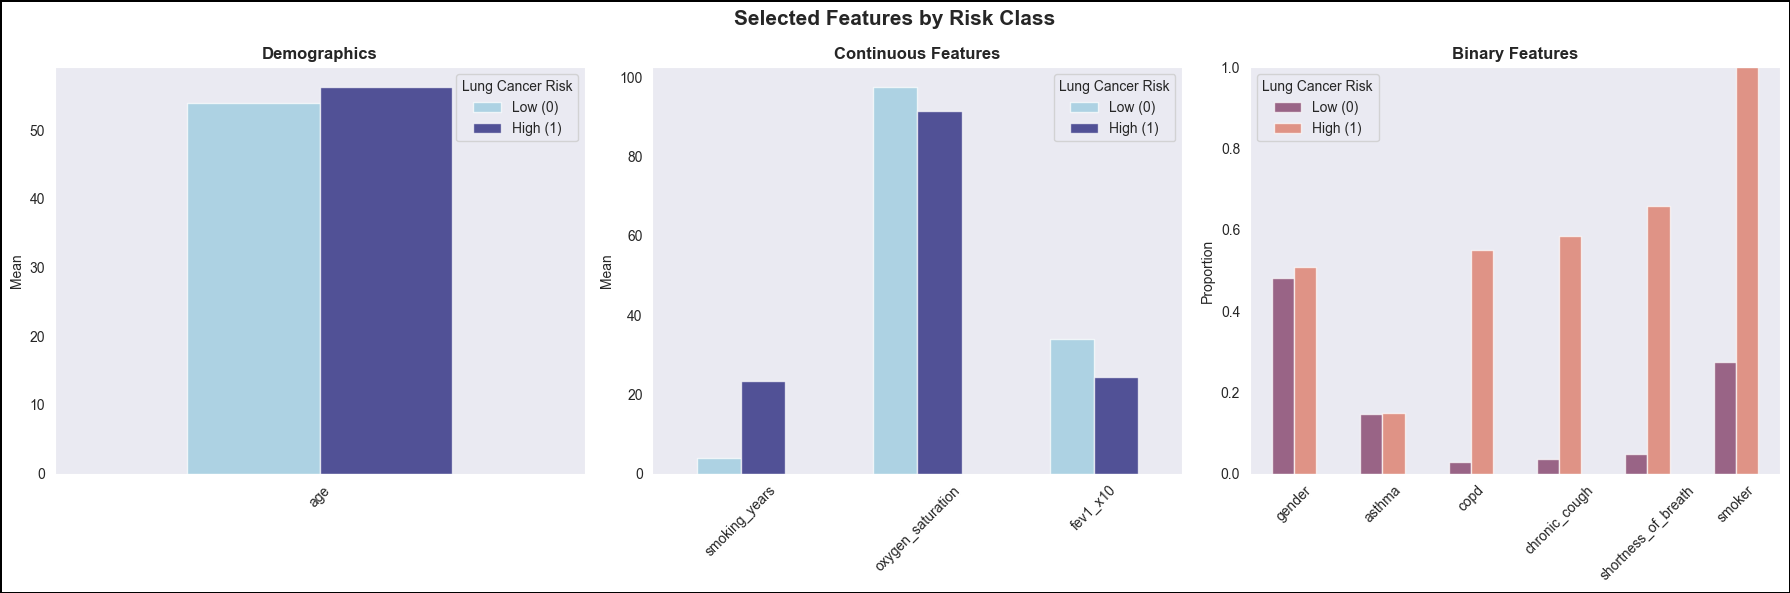

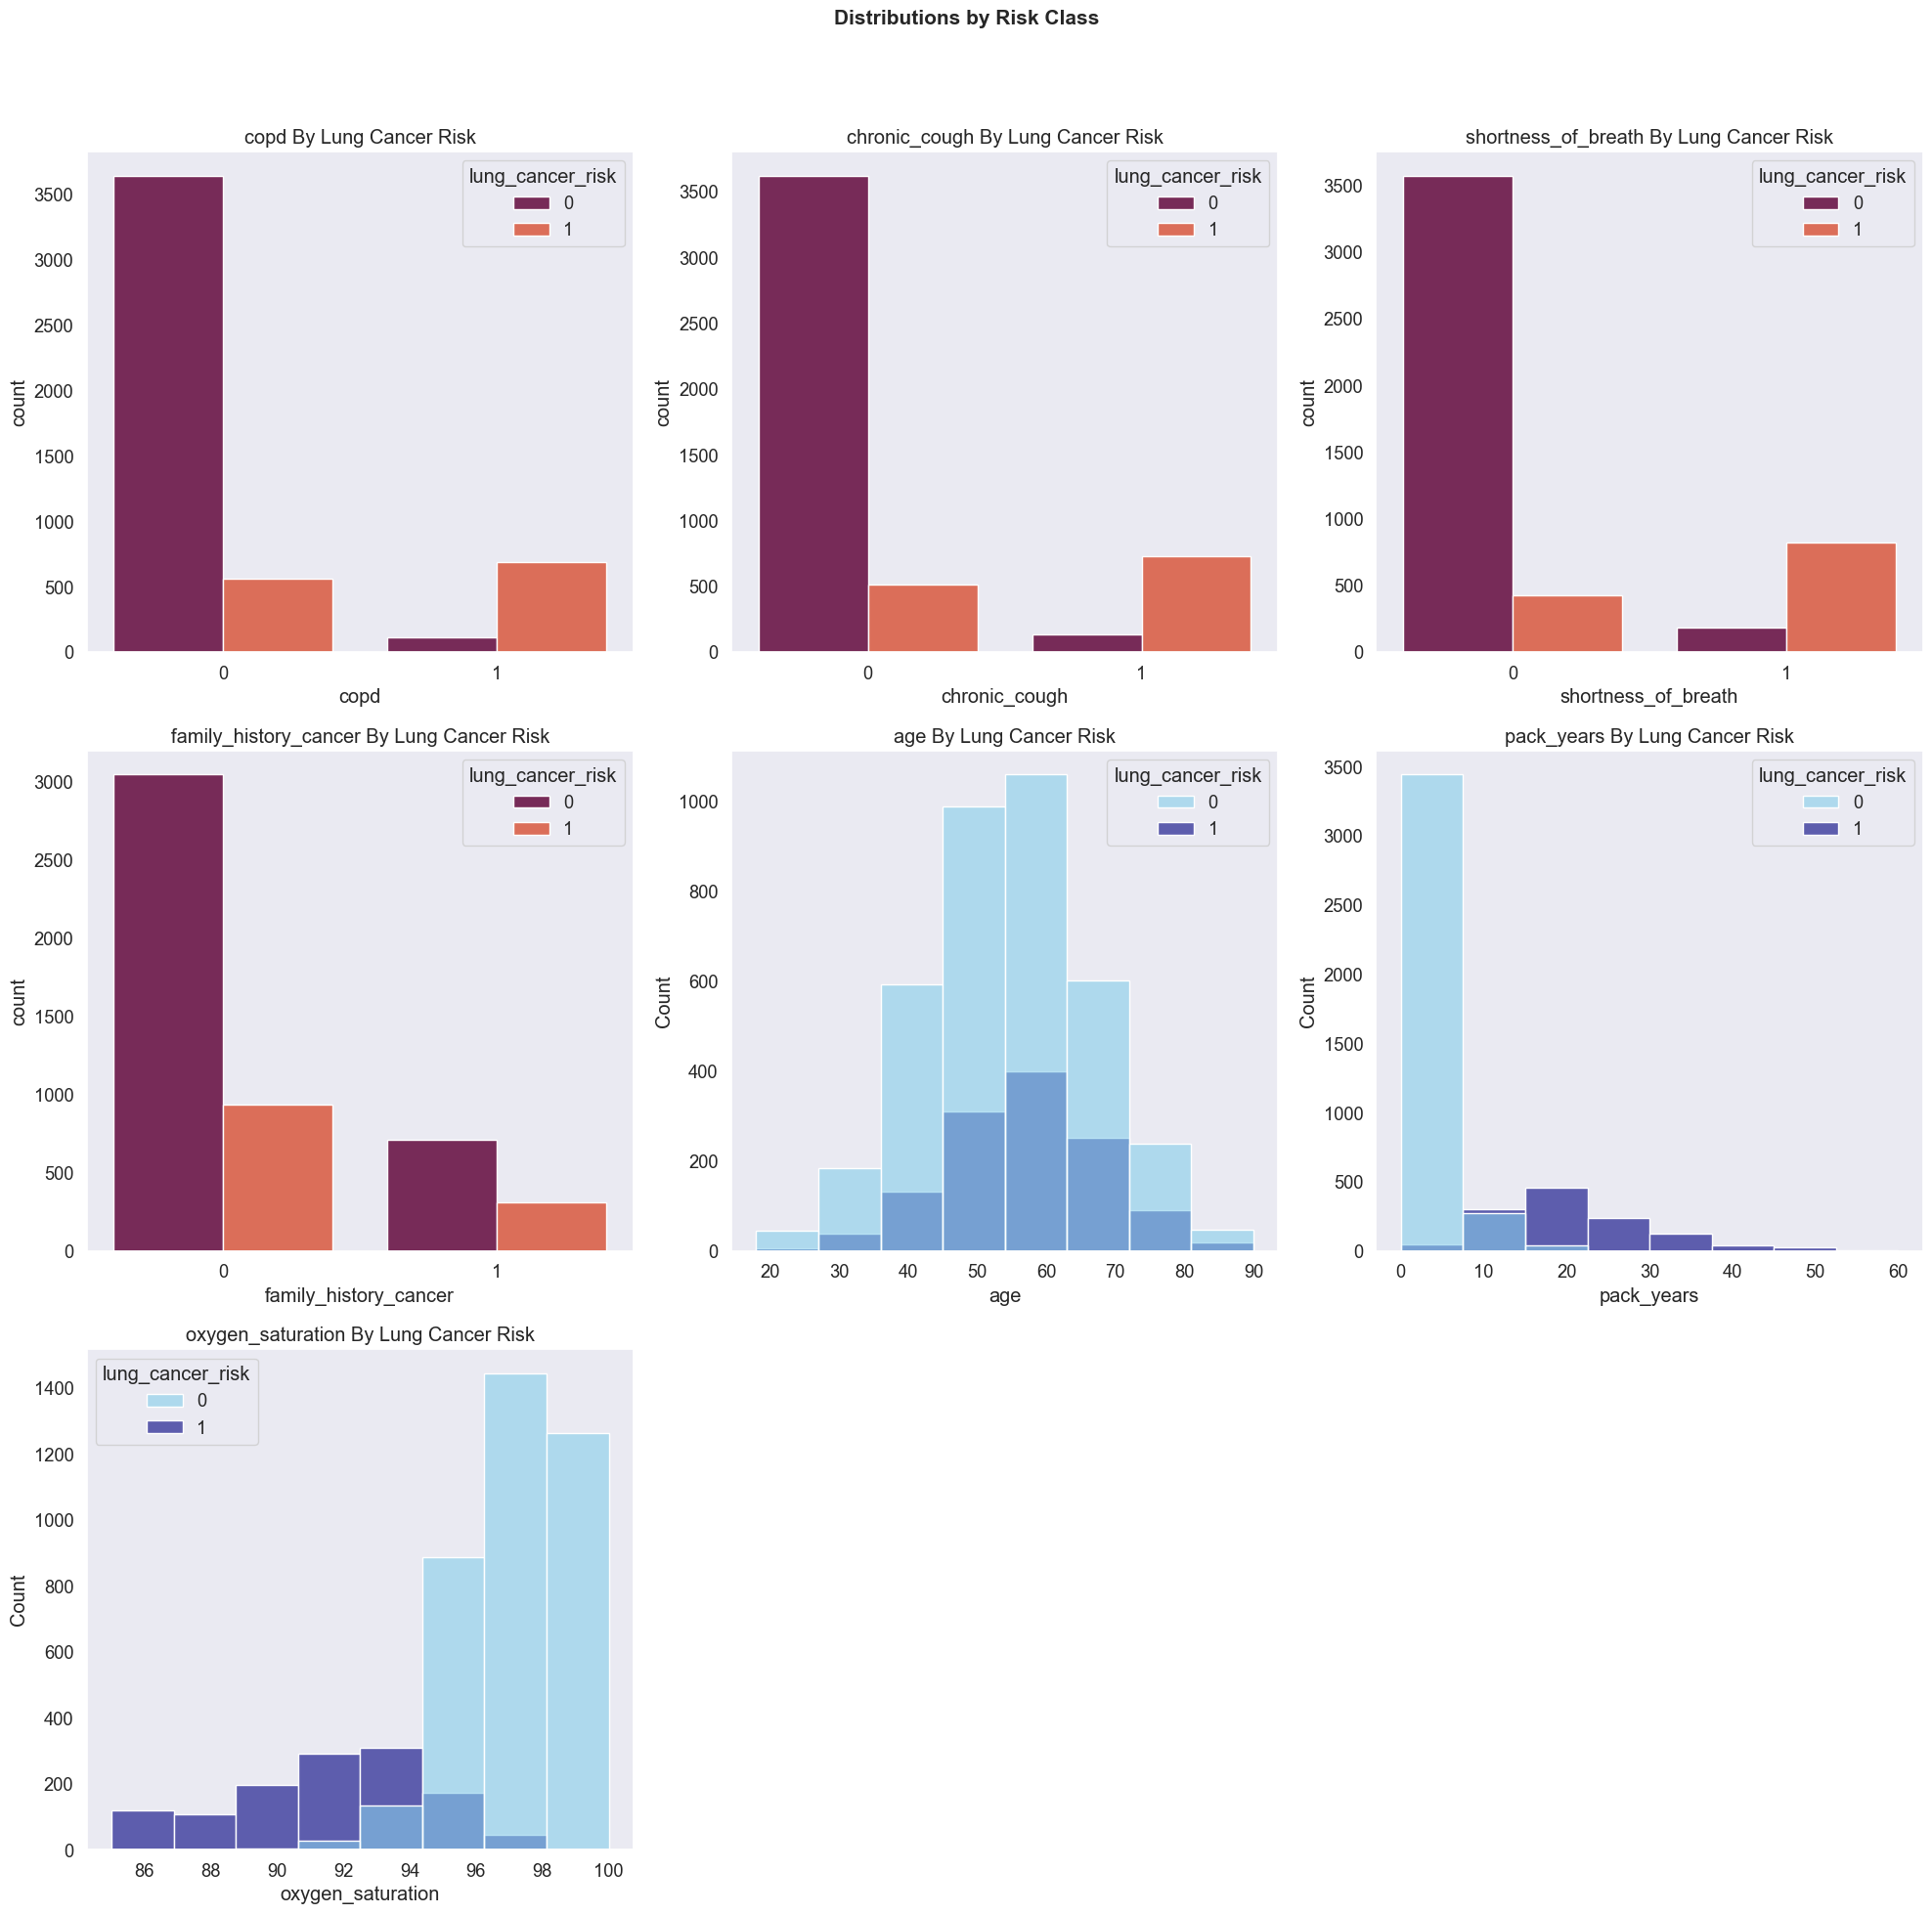

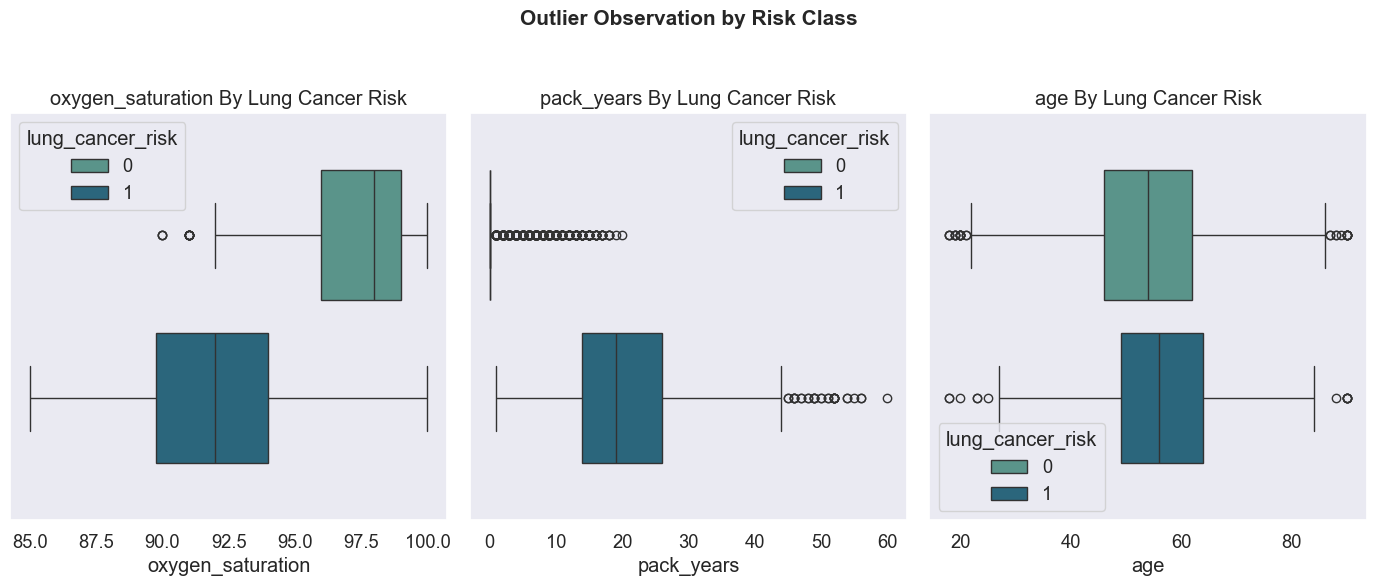

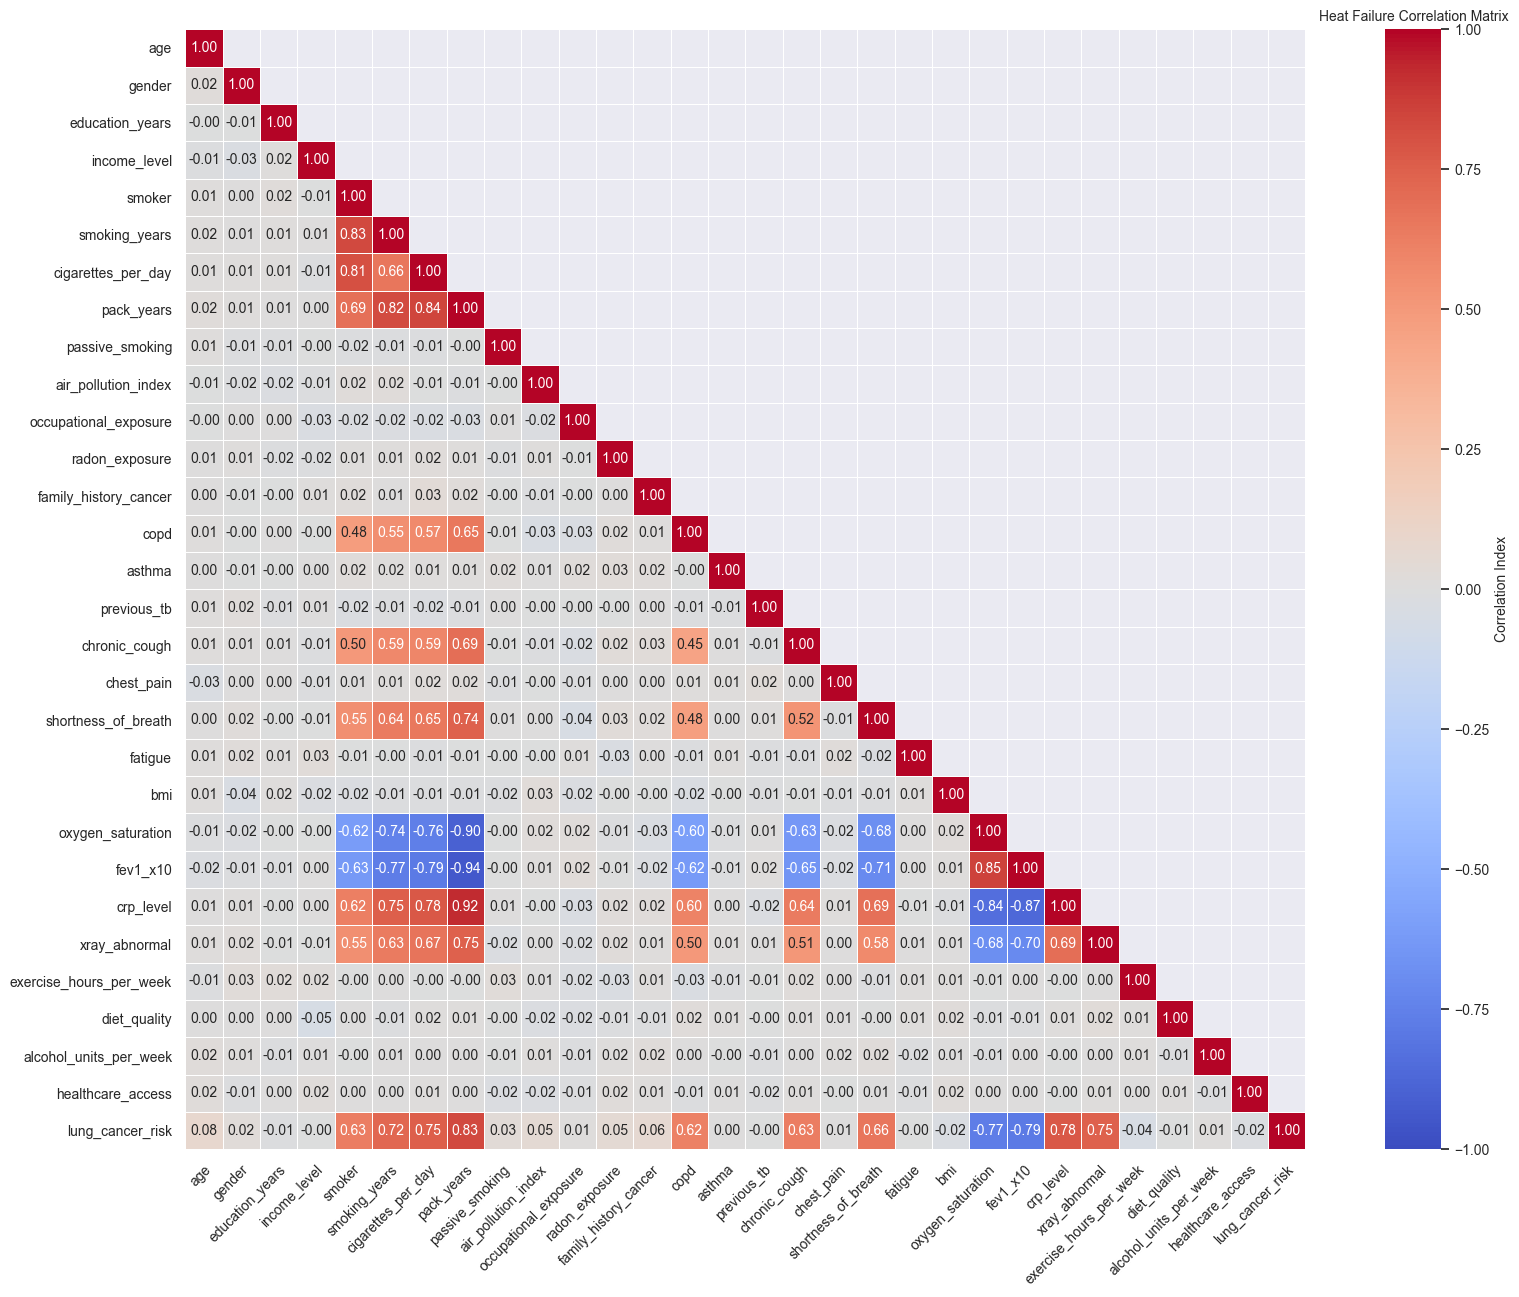

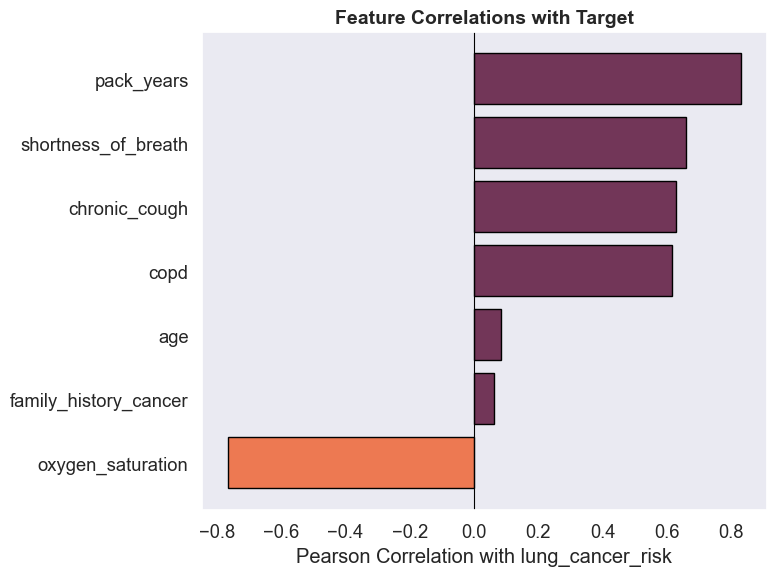





Total Execution time for EDA: 0:00:02.634820



In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)
timestamp_alltimes_start = datetime.now()
path = kagglehub.dataset_download("dhrubangtalukdar/lung-cancer-prediction-dataset")
df = pd.read_csv(path + '/lung_cancer.csv', sep=',', na_values=" ?", skipinitialspace=True)
TARGET = "lung_cancer_risk"

# ====== Significance Tesing ========
print("# ====== Significance Tesing ========")
# Continuous/discrete features
FEATURES_CONT = ["age", "pack_years", "oxygen_saturation"]
FEATURES_DISC  = ["copd", "family_history_cancer", "chronic_cough", "shortness_of_breath"]

# Low/HIgh risk data
low = df[df[TARGET] == 0]
hi = df[df[TARGET] == 1]

# Iterate thru continuous/discrete features applying relevant tests
for col in FEATURES_CONT:
    x0 = low[col]
    x1 = hi[col]

    t, p = ttest_ind(x0, x1, equal_var=False)

    print(dedent(f"""
{col}\np = {p:.3f} 
mean0 = {x0.mean():.3f}
mean1 = {x1.mean():.3f}
                 """))

for col in FEATURES_DISC:
    # build contignecy table
    table = pd.crosstab(df[TARGET], df[col])
    table = table.reindex(index=[0, 1], columns=[0, 1], fill_value=0)

    # Independence test
    chi2, p_val, dof, expect = chi2_contingency(table, correction=False)

    # Proportions
    lows = table.loc[0, 1] / table.loc[0].sum()
    highs = table.loc[1, 1] / table.loc[1].sum()
    
    print(dedent(f"""
{col}\np = {p_val:.3f}
{'Significant' if p_val < 0.05 else 'Not significant'} 
P({col}=1 | Low) = {lows:.3f}
P({col}=1 | High) = {highs:.3f}
                 """))

print(dedent(f"""
INTERPRETATION
---------------
For the CONTINUOUS features:

AGE:
HIgh risk patients are, on average, older
(mean_high = {hi['age'].mean():.3f} vs
mean_low = {low['age'].mean():.3f})
p < 0.001, meaning a significant difference.

PACK_YEARS:
High risk patients typically have more years smoking.
mean_high = {hi['pack_years'].mean():.3f}
mean_low = {low['pack_years'].mean():.3f}
p < 0.001, so smoking history has a strong association with risk.

OXYGEN SATURATION:
Lower oxygen saturation levels for high risk patients.
mean_high = {hi['oxygen_saturation'].mean():.3f}
mean_low = {low['oxygen_saturation'].mean():.3f}
p < 0.001, which implies many things like, exercise matters.
                 """))


# =========== EDA =============
print("======== Preview of Data ======== ")
print(f"Sample of the data:\n{df.head()}")
print(f"\n(Rows, Columns) = {df.shape}\n")
df.info()
print(f"\nDescribe (numeric data): {df.describe()}")
print(f"\nNumber of duplicated rows: {df.duplicated().sum()}")
print(f"\nNumber of Null Values: {df.isnull().sum().sum()}")
print(f"\nProportion of high-risk patients: {(df[TARGET].sum() / len(df[TARGET])) * 100}%")

# Categorizing columns by type using Claude
BINARY_COLS = [
    "gender", "smoker", "passive_smoking", "occupational_exposure",
    "radon_exposure", "family_history_cancer", "copd", "asthma",
    "previous_tb", "chronic_cough", "chest_pain", "shortness_of_breath",
    "fatigue", "xray_abnormal"
]

ORDINAL_COLS = ["income_level", "diet_quality", "healthcare_access"]

CONTINUOUS_COLS = [
    "age", "education_years", "smoking_years", "cigarettes_per_day",
    "pack_years", "air_pollution_index", "bmi", "oxygen_saturation",
    "fev1_x10", "crp_level", "exercise_hours_per_week",
    "alcohol_units_per_week"
]

# =========== Additional Descriptive Stats =============
print("\n======== Descriptive Stats by Risk Class ========")
grouped = df.groupby(TARGET)[CONTINUOUS_COLS].agg(["mean", "std", "median"])
grouped_stacked = grouped.stack(level=0)
grouped_stacked.index.names = ["risk_class", "feature"]
print(grouped_stacked.round(2).to_string())

print("\n======== Skewness & Kurtosis (Continuous Features) ========")
skew_kurt = pd.DataFrame({
    "Skewness": df[CONTINUOUS_COLS].skew(),
    "Kurtosis": df[CONTINUOUS_COLS].kurtosis()
}).round(3)
print(skew_kurt.to_string())

# Color constants
purple = "#723658"
orange = "#ed7952"
EDGE = "black"

# =========== Plots =============
# ---- Target Distribution ----
fig, ax = plt.subplots(figsize=(6,6))
sns.countplot(data=df, x='lung_cancer_risk', palette="rocket", ax=ax)
total = len(df)
for p in ax.patches:
    count = int(p.get_height())
    percent = 100 * count / total

    ax.text(
        p.get_x() + p.get_width()/2,
        count + total*0.01,
        f"{count}\n({percent:.1f}%)",
        ha="center"
    )

ax.set_ylim(0, ax.get_ylim()[1] * 1.15)
ax.set_xticks([0, 1])
ax.set_xticklabels(["Low Risk (0)", "High Risk (1)"])
ax.set_xlabel(" Lung Cancer Risk")
ax.set_title("Target Variable Distribution")
plt.tight_layout()
plt.show()
print("\n\n\n")

# ---- Proportion Mean Plots ----
# Continuous features use the mean to show the average value per risk group.
# Binary (0/1) features use the mean to show the proportion of 1s in each group.

#use dark grid to match seaborn figures
sns.set_style("dark")
custom_palette = {0: "skyblue", 1: "navy"}

#adding  grid to make it look like one figure
#Sorting by demo, cont and bin (makes it look like 3 figure butits one )
DEMO = ["age"]
CONT = ["smoking_years", "oxygen_saturation", "fev1_x10"]
BIN  = ["gender", "asthma", "copd", "chronic_cough", "shortness_of_breath", "smoker"]

# keep only columns that exist
DEMO = [c for c in DEMO if c in df.columns]
CONT = [c for c in CONT if c in df.columns]
BIN  = [c for c in BIN  if c in df.columns]

def panel(ax, cols, title, palette, ylim=None, ylabel="Mean", alpha=0.7):
    # seaborn computes the mean per TARGET internally
    sub = df.melt(id_vars=TARGET, value_vars=cols, var_name="feature", value_name="value")
    sns.barplot(data=sub, x="feature", y="value", hue=TARGET,
                palette=palette, errorbar=None, ax=ax, alpha=alpha, width=0.5)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    ax.tick_params(axis="x", rotation=45)
    if ylim:
        ax.set_ylim(*ylim)
    ax.legend(title="Lung Cancer Risk", labels=["Low (0)", "High (1)"])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

panel(axes[0], DEMO, "Demographics", custom_palette, ylabel="Mean")
panel(axes[1], CONT, "Continuous Features", custom_palette, ylabel="Mean")
panel(axes[2], BIN,  "Binary Features", "rocket", ylim=(0, 1),
      ylabel="Proportion")

plt.suptitle("Selected Features by Risk Class", fontsize=15, fontweight="bold")
plt.tight_layout()
# Add border around entire figure
fig.patch.set_edgecolor("black")
fig.patch.set_linewidth(2)
plt.show()
print("\n\n\n")

# ---- Continuous Distributions By Class ----
def features_by_target(df, column_plot, num_cols, w, h, title):
  sns.set(font_scale=1.2, style="dark")
  custom_palette = {0: 'skyblue', 1: 'navy'}

  keys_list = list(column_plot.keys())
  values_list = list(column_plot.values())

  n_plots = len(column_plot)
  n_cols = num_cols
  n_rows = int(math.ceil(n_plots/n_cols))

  gs = gridspec.GridSpec(n_rows, n_cols)
  fig = plt.figure(figsize=(w,h))

  for i in range(n_plots):
   ax = fig.add_subplot(gs[i])
   if values_list[i] == 'hist':
     sns.histplot(data=df, x=keys_list[i], hue='lung_cancer_risk', palette=custom_palette, bins=8, alpha=0.6, ax=ax)
   elif values_list[i] == 'count':
     sns.countplot(data=df, x=keys_list[i], hue='lung_cancer_risk', palette="rocket", ax=ax)
   elif values_list[i] == 'box':
     sns.boxplot(data=df, x=keys_list[i], hue='lung_cancer_risk', palette="crest", ax=ax, gap=0.2);
   else:
     print('Incorrect plot type, please check if column_plot has hist, count or box plots only.')
   ax.set_xlabel(keys_list[i])
   ax.set_title(f"{keys_list[i]} By Lung Cancer Risk")
  fig.suptitle(title, fontsize=15, fontweight="bold", y=0.98)
  plt.tight_layout(rect=[0, 0, 1, 0.95])

#Print Count and Histogram Plots
column_plot = {'copd': 'count','chronic_cough':'count','shortness_of_breath':'count',
               'family_history_cancer':'count','age':'hist', 'pack_years':'hist', 'oxygen_saturation': 'hist'}
features_by_target(df, column_plot, 3, 20, 20, 'Distributions by Risk Class')
plt.show()
print("\n\n\n")

#Print Box Plots
column_plot = {'oxygen_saturation':'box', 'pack_years':'box', 'age':'box'}
features_by_target(df, column_plot, 3, 14, 6, 'Outlier Observation by Risk Class')
plt.show()
print("\n\n\n")

# ---- Correlation Heatmap ----
#(Shpaner & Gil, 2024)
df_num = df.select_dtypes(np.number)
flex_corr_matrix(
    df=df,
    cols=df_num.columns.to_list(),
    annot=True,
    cmap="coolwarm",
    figsize=(18, 14),
    title="Heat Failure Correlation Matrix",
    xlabel_alignment="right",
    label_fontsize=10,
    tick_fontsize=10,
    xlabel_rot=45,
    ylabel_rot=0,
    text_wrap=50,
    vmin=-1,
    vmax=1,
    cbar_label="Correlation Index",
    triangular=True,
)
print("\n\n\n")

# ---- Narrowed Down Correlations with Target ----
narrowed_df = df[["age", "pack_years", "copd", "family_history_cancer",
                  "chronic_cough", "shortness_of_breath", "oxygen_saturation", "lung_cancer_risk"]]
corr = narrowed_df.corr()
fig, ax = plt.subplots(figsize=(8, 6))
target_corr = corr[TARGET].drop(TARGET).sort_values()
colors = [purple if v > 0 else orange for v in target_corr.values]
ax.barh(target_corr.index, target_corr.values, color=colors, edgecolor=EDGE)
ax.set_xlabel("Pearson Correlation with lung_cancer_risk")
ax.set_title("Feature Correlations with Target",
             fontsize=14, fontweight="bold")
ax.axvline(0, color="black", linewidth=0.8)
plt.tight_layout()
plt.show()
print("\n\n\n")

timestamp_alltimes_end = datetime.now()
print(f"\033[1;32mTotal Execution time for EDA: {timestamp_alltimes_end - timestamp_alltimes_start}\n")



In [12]:
timestamp_logistic_start = datetime.now()

#Define the independent and dependent variables
X = df[['age','pack_years','copd','family_history_cancer','chronic_cough', 'shortness_of_breath','oxygen_saturation']]
y = df[TARGET]

#Split the data into train and test sets: 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Generate a pipeline to scale the data using a standard scaler and fit the logistic regression model
pipe = Pipeline([("scaler", StandardScaler()),("logreg", LogisticRegression())])
model1 = pipe.fit(X_train, y_train)

#Calculate the prediction and probability of the dependent variable
y_pred1 = pipe.predict(X_test)
y_prob1 = pipe.predict_proba(X_test)[:, 1]

#Print model metrics
print("Accuracy:", accuracy_score(y_test, y_pred1))

timestamp_logistic_end = datetime.now()
print(f"\033[1;32mTotal Execution time for Logistic Regression Model: {timestamp_logistic_end - timestamp_logistic_start}\n")

Accuracy: 0.962
Total Execution time for Logistic Regression Model: 0:00:00.027120



In [ ]:
#Predicting the risk for a 30 yo patient with pack years of 20, no COPD or
#family history of cancer or shortness of breath, existing chronic cough
# and oxgen saturation of 98.
patient = pd.DataFrame([{
    'age': 30,
    'pack_years': 20,
    'copd': 0,
    'family_history_cancer': 0,
    'chronic_cough': 1,
    'shortness_of_breath': 0,
    'oxygen_saturation' : 98
}])

risk_prob = pipe.predict_proba(patient)[0][1]
print("Predicted risk:", round(risk_prob,2))

In [13]:
timestamp_forest_start = datetime.now()

def rf_model(random_state=73):
    """
    Baseline Random Forest model
    """
    return RandomForestClassifier(
        # Number of Decision trees in forest (500)
        n_estimators=500,
        # n_samples / (n_classes * np.bincount(y))
        class_weight="balanced",
        # NO depth limit
        max_depth=None,
        # Subset fo features to consider for best split: sqrt(n_features)
        max_features="sqrt",
        # Minimum number of samples to split (internal node)
        min_samples_split = 2,
        # Samples on right/left branch required for each leaf node
        min_samples_leaf=5, # 5 was chosen to reduce variance (default=1)
        # Random seed for reproducibility
        random_state=73,
        # Out-of-bag score for estimates generalization w/out using test data
        oob_score=True,
        # Use all CPU cores
        n_jobs=-1
    )

# Fitting Random Forest Classifier
# Unlike Logistic Regression, scaling is NOT required because trees split on thresholds so feature magnitudes don't affect the splits.
forest = rf_model()
model2 = forest.fit(X_train, y_train)
y_pred2 = forest.predict(X_test)
y_prob2 = forest.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred2))

timestamp_forest_end = datetime.now()
print(f"\033[1;32mTotal Execution time for Random Forest Model: {timestamp_forest_end - timestamp_forest_start}\n")

Accuracy: 0.951
Total Execution time for Random Forest Model: 0:00:00.622161



In [33]:
#Predicting the risk for a 30 yo patient with pack years of 20, no COPD or
#family history of cancer or shortness of breath, existing chronic cough
# and oxgen saturation of 98.
patient = pd.DataFrame([{
    'age': 30,
    'pack_years': 20,
    'copd': 0,
    'family_history_cancer': 0,
    'chronic_cough': 1,
    'shortness_of_breath': 0,
    'oxygen_saturation' : 98
}])

risk_prob = forest.predict_proba(patient)[0][1]
print("Predicted risk:", round(risk_prob,2))

Predicted risk: 0.64


In [15]:
#(Shpaner, 2025)
model_titles = ["Logistic Regression", "Random Forest"]

model_performance = summarize_model_performance(
    model=[model1, model2],
    model_title=model_titles,
    X=X_test,
    y=y_test,
    model_type="classification",
    return_df=True
)

model_performance

,Metrics,Logistic Regression,Random Forest
,Precision/PPV,0.934,0.868
,Average Precision,0.978,0.970
,Sensitivity/Recall,0.912,0.948
,Specificity,0.979,0.952
,F1-Score,0.923,0.906
,AUC ROC,0.992,0.989
,Brier Score,0.031,0.038
,Model Threshold,0.500,0.500


Confusion Matrix for Logistic Regression: 

          Predicted 0  Predicted 1
Actual 0          735           16
Actual 1           22          227

Confusion Matrix for Random Forest: 

          Predicted 0  Predicted 1
Actual 0          715           36
Actual 1           13          236



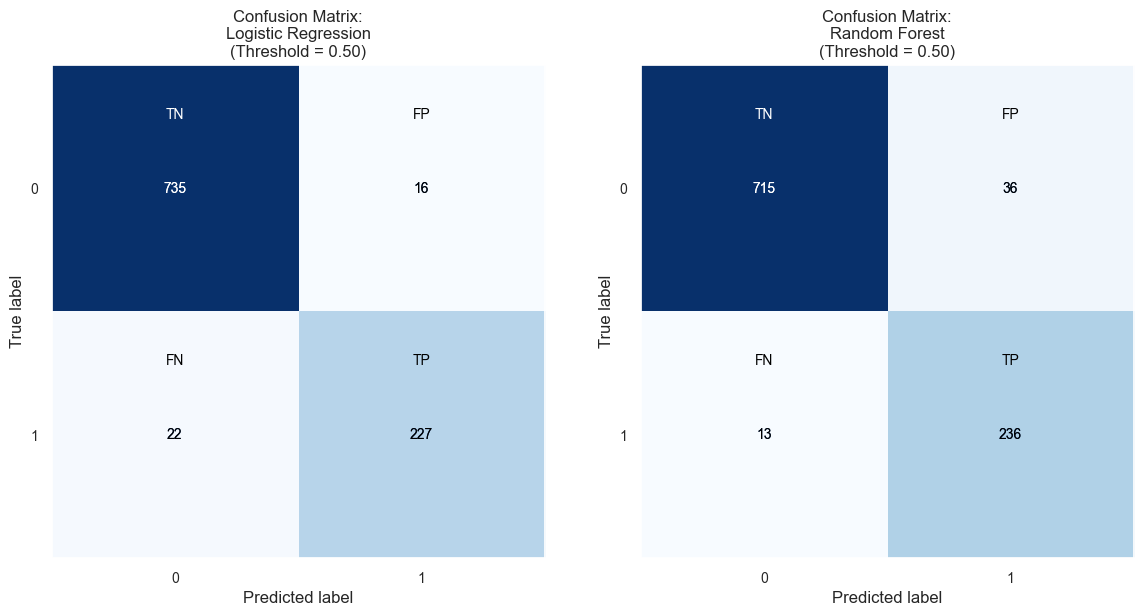

In [16]:
#Confusion matrix
#(Shpaner, 2025)
show_confusion_matrix(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    cmap="Blues",
    text_wrap=20,
    subplots=True,
    n_cols=2,
    n_rows=1,
    figsize=(6, 6),
)

AUC for Logistic Regression: 0.99
AUC for Random Forest: 0.99


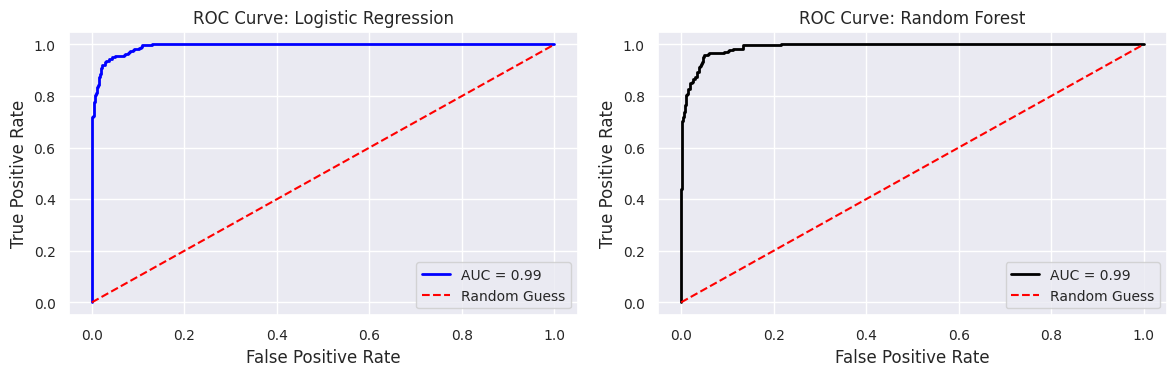

In [36]:
#ROC Curve
#(Shpaner, 2025)
show_roc_curve(
    model=[model1, model2],
    X=X_test,
    y=y_test,
    model_title=model_titles,
    decimal_places=2,
    n_cols=2,
    n_rows=1,
    curve_kwgs={
        "Logistic Regression": {"color": "blue", "linewidth": 2},
        "Random Forest": {"color": "black", "linewidth": 2},
    },
    linestyle_kwgs={"color": "red", "linestyle": "--"},
    subplots=True,
)

References:

Harris, C. R., et al. (2020). Array programming with NumPy. Nature, 585, 357–362. https://doi.org/10.1038/s41586-020-2649-2

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95.

McKinney, W. (2010). pandas [Computer software]. https://pandas.pydata.org/

Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830.

Python Software Foundation. (2024). Python (Version 3.x) [Computer software]. https://www.python.org/

Shpaner, L., & Gil, O. (2024). EDA Toolkit (Version 0.2.2) [Computer software]. Zenodo. https://doi.org/10.5281/zenodo.13162633

Shpaner, L. (2025). Model Metrics (0.0.5a6). Zenodo. https://doi.org/10.5281/zenodo.14879819

Virtanen, P., et al. (2020). SciPy 1.0: Fundamental algorithms for scientific computing in Python. Nature Methods, 17, 261–272.

Waskom, M. L. (2021). seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021